In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/advanced-dls-spring-2021/submission.csv
/kaggle/input/advanced-dls-spring-2021/train.csv
/kaggle/input/advanced-dls-spring-2021/test.csv


# 1. Анализ данных

In [2]:
df_train = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
df_test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

In [3]:
df_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [4]:
# Смотрим на данные, разбиваем призанкаи на численные и категориальные

In [5]:
cat_cols = ['Sex', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']
num_cols = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
target = ['Churn']
feature_cols = num_cols + cat_cols + target

In [6]:
# Циклом пройдемся и посмотрим на переменные в столбцах
for i in df_train.columns:
    print(pd.DataFrame(df_train[i].value_counts()))
    print('*******************************')
    print(pd.DataFrame(df_train.groupby('Churn')[i].value_counts()),)
    print('###############################')

    ClientPeriod
1            457
72           284
2            165
3            162
4            136
..           ...
57            39
39            35
44            34
36            34
0              9

[73 rows x 1 columns]
*******************************
                    ClientPeriod
Churn ClientPeriod              
0     72                     279
      1                      175
      71                     126
      70                      88
      3                       87
...                          ...
1     61                       4
      62                       4
      63                       4
      44                       3
      64                       3

[145 rows x 1 columns]
###############################
       MonthlySpending
20.05               46
19.65               35
19.95               34
20.00               33
19.70               32
...                ...
87.30                1
68.90                1
67.20                1
86.30                1
98.

## 1.1. Первые выводы

In [7]:
#  в последующем нужно убирать пол и мультителефонию, так как одинаковые рапределения , ниже увидим подробнее
#  необходимо продумть что делать с дисбалансом таргета. анализ зависимостей делать с учетом дисбаланса

# 2. Графические распределения

In [8]:
# Посмотрим  графически на распеределения категориальных признаков

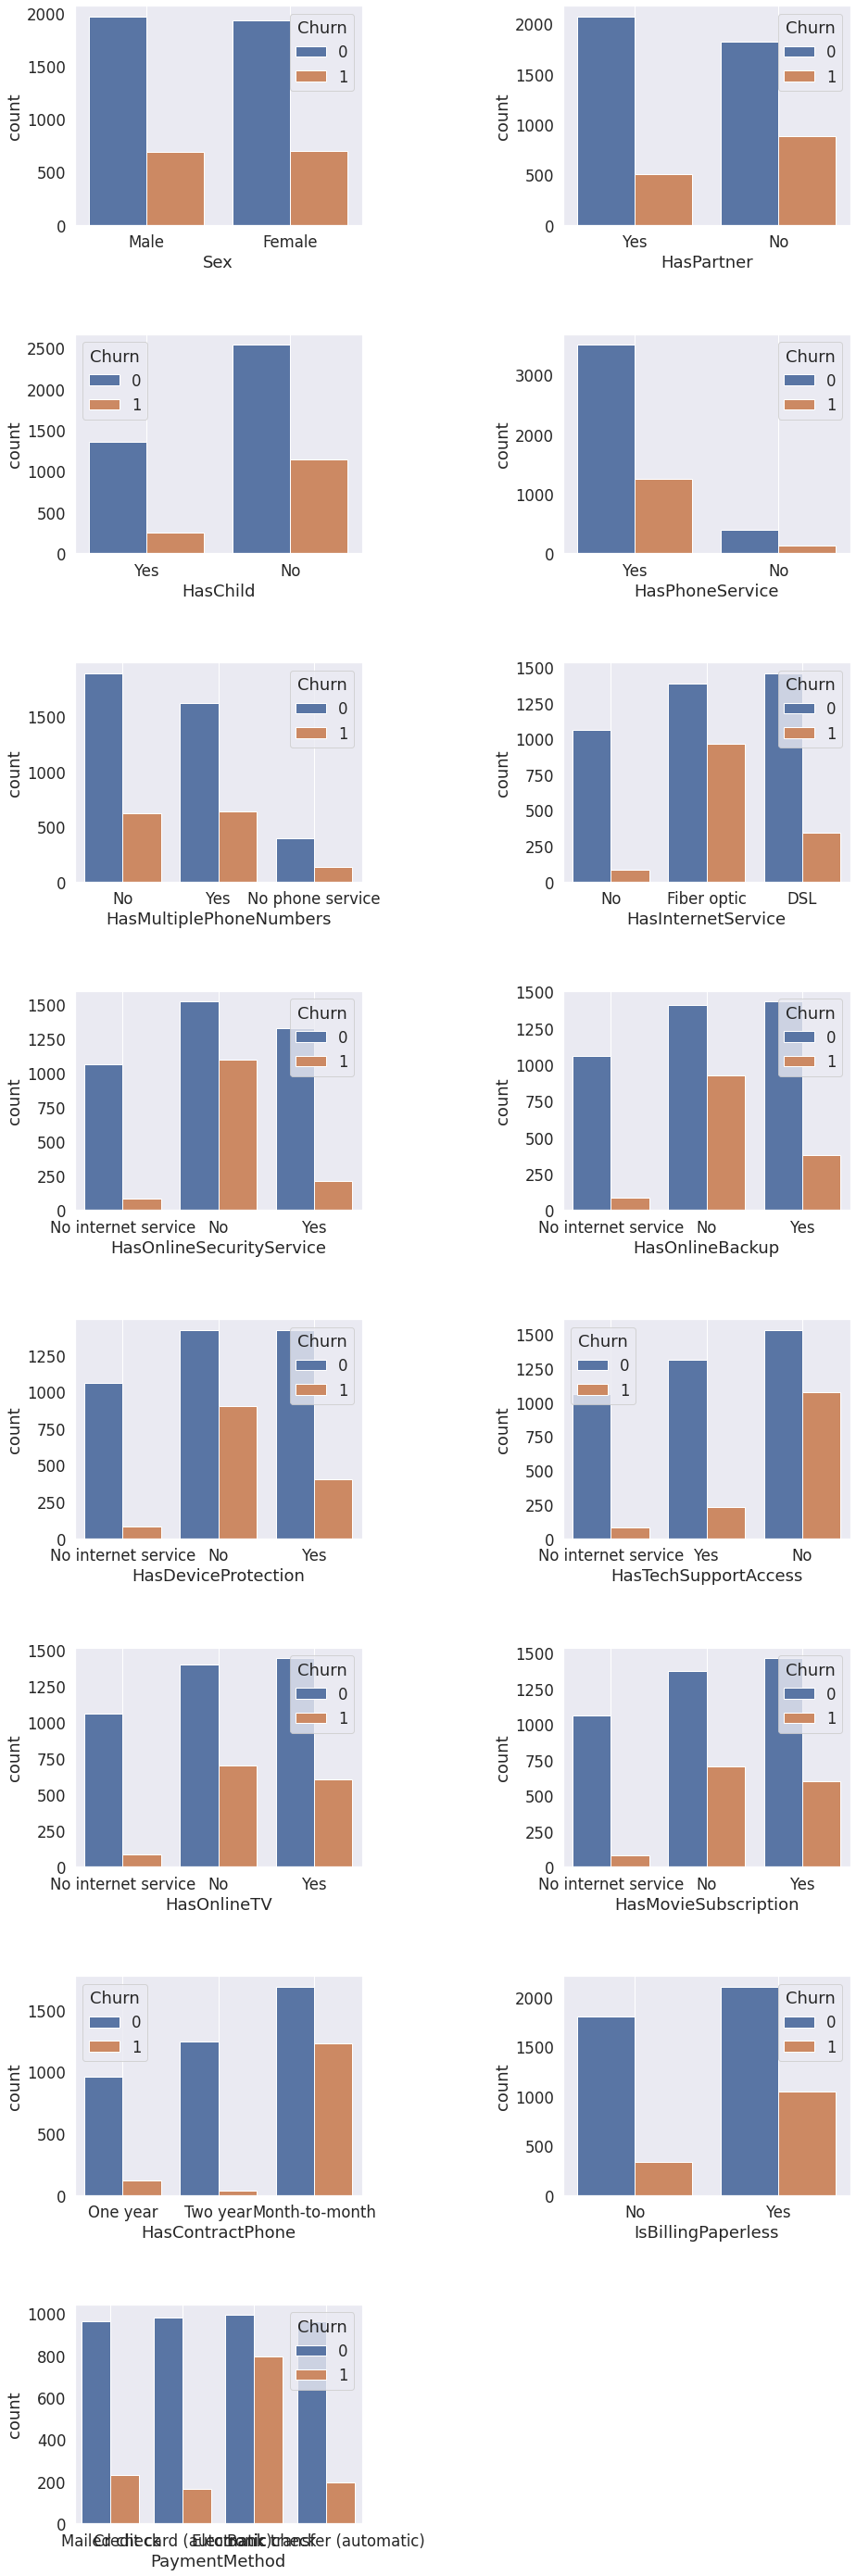

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(15,50))

for i, j in enumerate(cat_cols):
    plt.subplot(8,2,i+1)
    sns.countplot(data=df_train, x=df_train[j],hue = 'Churn')
    #plt.hist(df_train[j])
    #plt.title(cat_cols[i])
    plt.subplots_adjust(hspace = 0.5,wspace =0.7)
    plt.grid()
    
plt.show()

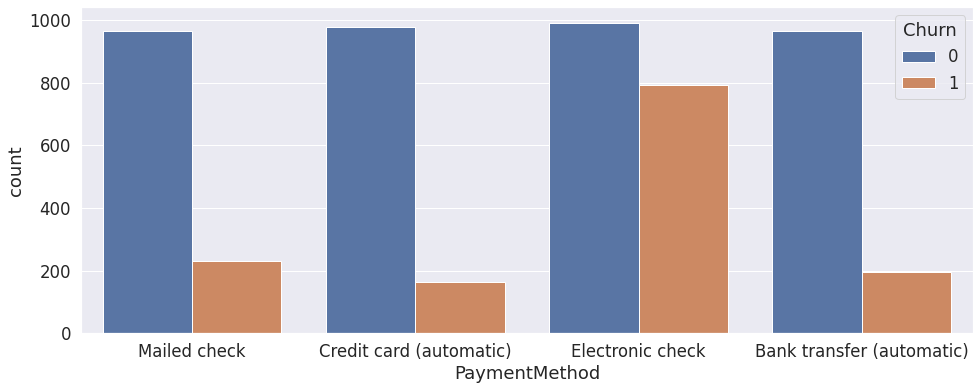

In [10]:
plt.figure(figsize =(16,6))
sns.countplot(data=df_train, x='PaymentMethod',hue = 'Churn')
#plt.hist(df_train['PaymentMethod'])
None

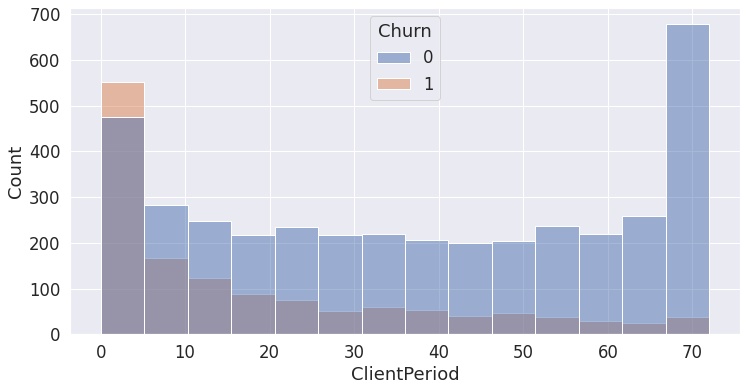

In [11]:
plt.figure(figsize=(12,6))
sns.histplot(data=df_train, x=df_train[num_cols[0]],hue = 'Churn')
None

<AxesSubplot:xlabel='ClientPeriod', ylabel='count'>

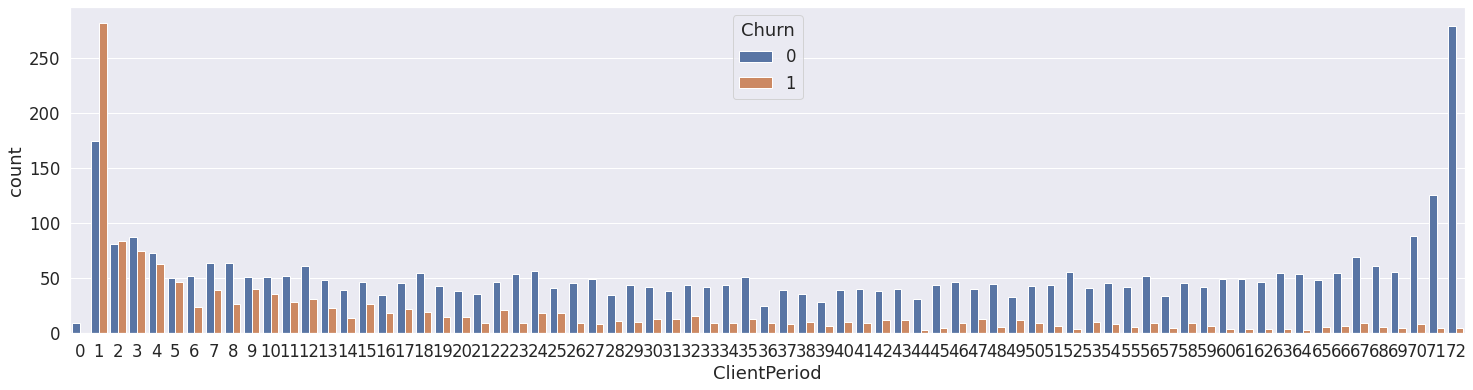

In [12]:
plt.figure(figsize=(25,6))
sns.countplot(data=df_train, x=df_train[num_cols[0]],hue = 'Churn')

<AxesSubplot:xlabel='MonthlySpending', ylabel='Count'>

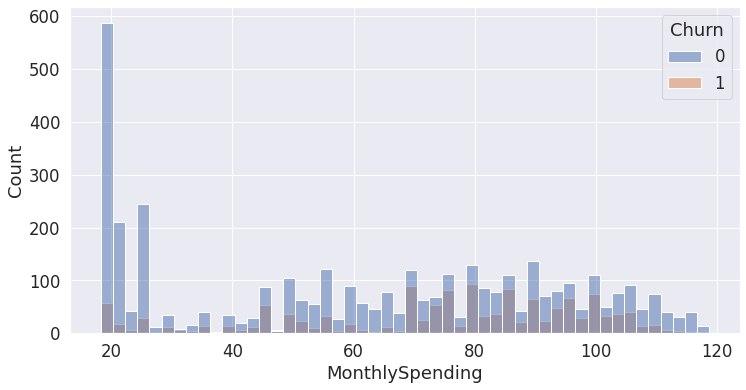

In [13]:
plt.figure(figsize=(12,6))
sns.histplot(data=df_train, x=df_train[num_cols[1]],hue = 'Churn',bins = 50)  # месячные расходы

In [14]:
#plt.figure(figsize=(18,6))
#sns.countplot(data=df_train, x=df_train['TotalSpent'],hue = 'Churn') 


In [15]:
# есть мысль ввести категорию затрат до 30, в этой категории чаще остаются

df_train['ost_1'] = df_train['MonthlySpending'].apply(lambda x: 1 if x < 30 else 0)
df_test['ost_1'] = df_test['MonthlySpending'].apply(lambda x: 1 if x < 30 else 0)



# есть мысль ввести категорию периода после 70, в этой категории чаще остаются

df_train['ost_2'] = df_train['ClientPeriod'].apply(lambda x: 1 if x > 71 else 0)
df_test['ost_2'] = df_test['ClientPeriod'].apply(lambda x: 1 if x > 71 else 0)

# перемножим призанки 
df_train['ost_3'] = df_train['ost_1']* df_train['ost_2']
df_test['ost_3'] = df_test['ost_1']* df_test['ost_2']



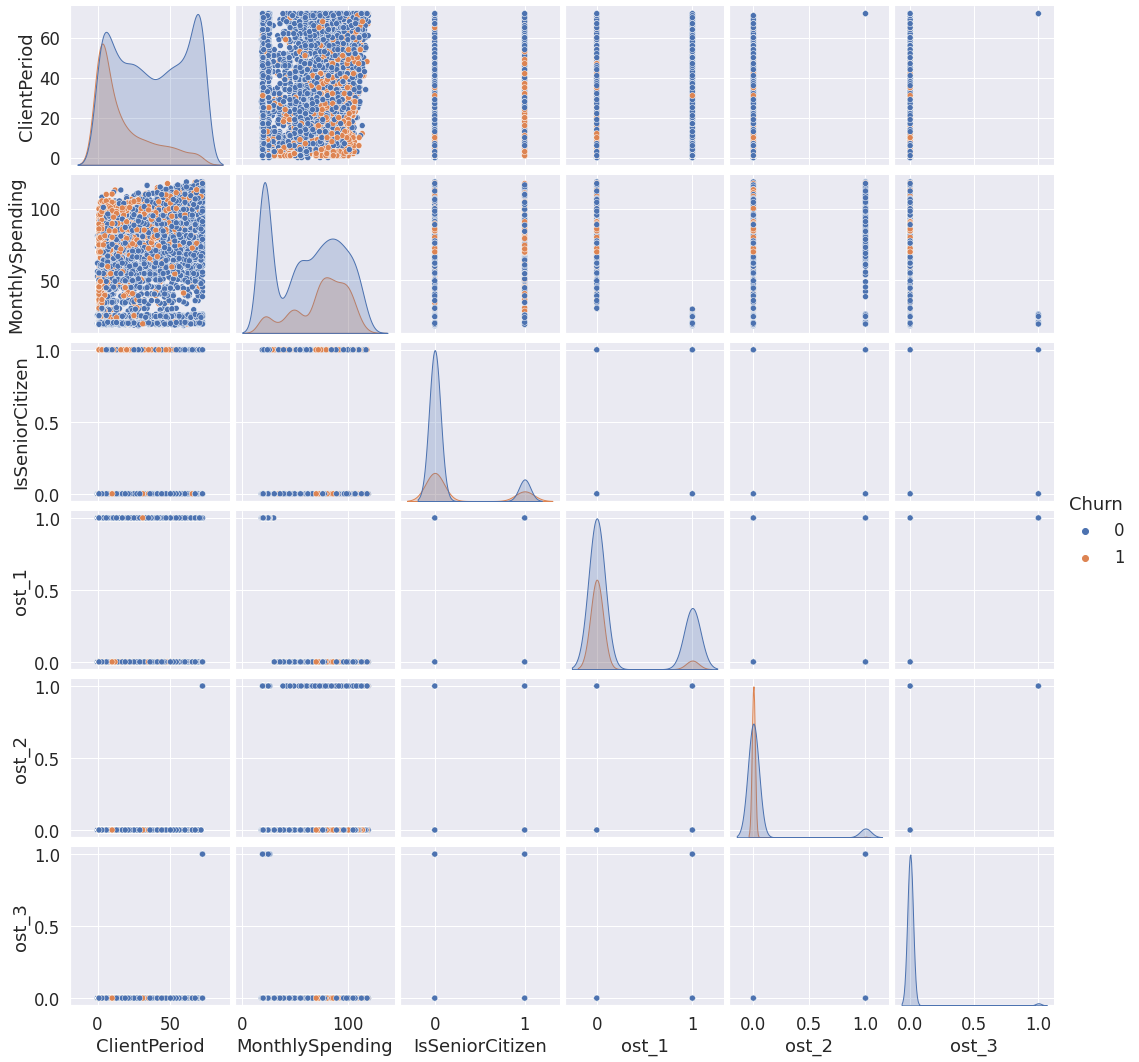

In [16]:
sns.pairplot(df_train,hue = 'Churn')

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [18]:
df_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,...,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,ost_1,ost_2,ost_3
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,...,No internet service,No internet service,No internet service,One year,No,Mailed check,0,1,0,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,...,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0,1,1,1
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,...,Yes,No,No,Month-to-month,Yes,Electronic check,1,0,0,0
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,...,No,No,No,Month-to-month,No,Mailed check,0,0,0,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Two year,No,Credit card (automatic),0,0,0,0


# 3. Отработка версий, заполнение данных тестирование признаков

In [19]:
#  стоит ли чтото делать с категориями с "No internet service" или "No phone service"  ? подменить на Nо ?


In [20]:
for i in cat_cols:
    df_train[i]=df_train[i].apply(lambda x : x.replace('No internet service','No') if x == 'No internet service' else x)
    df_train[i]=df_train[i].apply(lambda x : x.replace('No phone service','No') if x == 'No phone service' else x)
    df_train[i]=df_train[i].apply(lambda x : x.replace('No phone service','No') if x == 'No phone service' else x)
    

    df_test[i]=df_test[i].apply(lambda x : x.replace('No internet service','No') if x == 'No internet service' else x)
    df_test[i]=df_test[i].apply(lambda x : x.replace('No phone service','No') if x == 'No phone service' else x)
    df_test[i]=df_test[i].apply(lambda x : x.replace('No phone service','No') if x == 'No phone service' else x)
    


In [21]:
# отработка дропа признаков у которых одинаковые распределения при 1 и 0


In [22]:
df_train.drop(columns=['Sex','HasMultiplePhoneNumbers'],inplace=True)
df_test.drop(columns=['Sex','HasMultiplePhoneNumbers'],inplace=True)

In [23]:
cat_cols = ['HasPartner', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'PaymentMethod',
       'IsBillingPaperless','HasChild','HasPhoneService','ost_1','ost_2','ost_3']

In [24]:
df_train['TotalSpent'] = pd.to_numeric(df_train['TotalSpent'], errors='coerce')
df_test['TotalSpent'] = pd.to_numeric(df_test['TotalSpent'], errors='coerce')
df_train['TotalSpent'].fillna(0 , inplace = True) 
df_test['TotalSpent'].fillna(0, inplace = True)

In [25]:
#df_train['ost_4'] = df_train['TotalSpent'].apply(lambda x: 1 if x > 6000 else 0)
#df_test['ost_4'] = df_test['TotalSpent'].apply(lambda x: 1 if x > 6000 else 0)


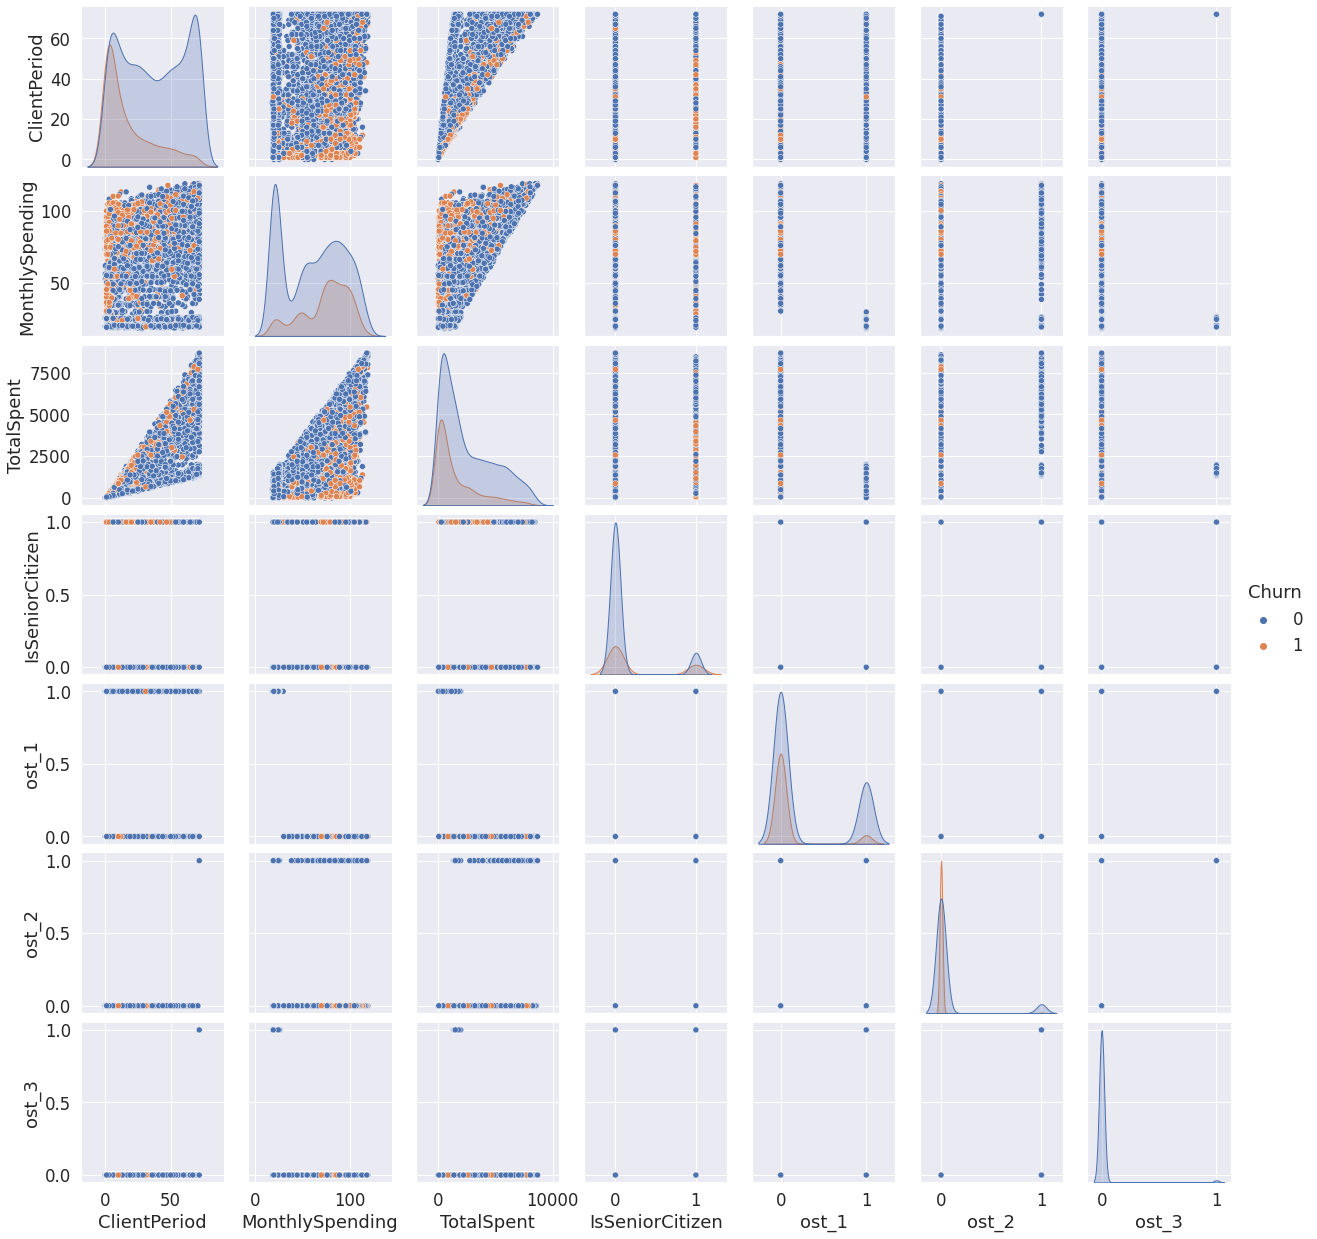

In [26]:
sns.pairplot(df_train,hue = 'Churn')

In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   IsSeniorCitizen           1761 non-null   int64  
 4   HasPartner                1761 non-null   object 
 5   HasChild                  1761 non-null   object 
 6   HasPhoneService           1761 non-null   object 
 7   HasInternetService        1761 non-null   object 
 8   HasOnlineSecurityService  1761 non-null   object 
 9   HasOnlineBackup           1761 non-null   object 
 10  HasDeviceProtection       1761 non-null   object 
 11  HasTechSupportAccess      1761 non-null   object 
 12  HasOnlineTV               1761 non-null   object 
 13  HasMovieSubscription      1761 non-null   object 
 14  HasContr

In [28]:
df_test.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
ost_1                       0
ost_2                       0
ost_3                       0
dtype: int64

In [29]:
df_train.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
ost_1                       0
ost_2                       0
ost_3                       0
dtype: int64

In [30]:
df_train.corr()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn,ost_1,ost_2,ost_3
ClientPeriod,1.000000,0.249414,0.826658,0.011561,-0.350640,-0.077739,0.384568,0.162420
MonthlySpending,0.249414,1.000000,0.652014,0.215456,0.184769,-0.797549,0.119433,-0.139378
TotalSpent,0.826658,0.652014,1.000000,0.094640,-0.200033,-0.404399,0.365095,-0.027418
IsSeniorCitizen,0.011561,0.215456,0.094640,1.000000,0.156872,-0.174816,-0.016675,-0.017896
Churn,-0.350640,0.184769,-0.200033,0.156872,1.000000,-0.208166,-0.132495,-0.059990
ost_1,-0.077739,-0.797549,-0.404399,-0.174816,-0.208166,1.000000,-0.027568,0.181290
ost_2,0.384568,0.119433,0.365095,-0.016675,-0.132495,-0.027568,1.000000,0.422345
ost_3,0.162420,-0.139378,-0.027418,-0.017896,-0.059990,0.181290,0.422345,1.000000


In [31]:
y = df_train['Churn']
X = df_train.drop(columns=['Churn'])
Xt = df_test.copy()

In [32]:
X = pd.get_dummies(X, columns=cat_cols)
Xt = pd.get_dummies(Xt, columns=cat_cols)

In [33]:
scaler = StandardScaler()
scaler.fit(X[num_cols])
X[num_cols] = pd.DataFrame(scaler.fit_transform(X[num_cols]))
# скалируем только тест по обучению трейна? фигня

Xt[num_cols] = pd.DataFrame(scaler.transform(Xt[num_cols]))

### Генерация новых признаков

In [34]:
#for i in range(1,len(X.columns)):
#    X[str(i)+'_xx'] = X.iloc[:,i] * X.iloc[:,i-1]
#    Xt[str(i)+'_xx'] = Xt.iloc[:,i] * Xt.iloc[:,i-1]
    
#for i in range(len(X.columns)):
#    X[str(i)+'_yy'] = X.iloc[:,i] ** 2
#    Xt[str(i)+'_yy'] = Xt.iloc[:,i] ** 2

# генерация признаков не помогает ROC падает

# Строим модели

## a.) Логистическая регрессия

Общая точность:   0.7975917431192661
ROC:   0.8308472492397053
LogisticRegression: ROC AUC=0.831


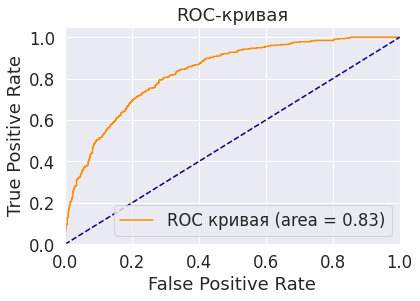

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


# разделяем его на 2 выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)
# обучаем модель
model_lr = LogisticRegression(solver='lbfgs')
model_lr.fit(X_train, y_train)
# получаем предказания
lr_probs = model_lr.predict_proba(X_test)
# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(f'Общая точность:   {model_lr.score(X_test, y_test)}')
print(f'ROC:   {roc_auc_score(y_test, model_lr.predict_proba(X_test)[:,1])}')
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))

# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

In [36]:
CV_Score = cross_val_score(model_lr, X, y, scoring='roc_auc', cv=5)
print(CV_Score)
CV_Score.mean()

[0.86139498 0.83730214 0.83491267 0.85581348 0.83524884]


0.844934422054922

In [37]:
# 0.8448047649324361

In [38]:
CV_Score = cross_val_score(model_lr, X, y, cv=5)
print(CV_Score)
CV_Score.mean()

[0.81929991 0.79848628 0.78882576 0.81723485 0.79924242]


0.8046178435251283

In [39]:
# 0.8038606261288381

### Веса для логистичекой регресии

In [40]:
# посмотрим на веса регресии:
#for i in range(len(X.columns)):
#    print(f'{X.columns[i]} score : {model_lr.coef_[0][i]}')

In [41]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)
#CBC = CatBoostClassifier(verbose=False)
#parameters = {'max_depth'         : [4,8],
#              'learning_rate' : [0.01,0.04, 0.05 ],
#              'iterations'    : [70]
#                 }
#Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 5, n_jobs=-1).\
#fit(X_train,y_train)
#print(" Results from Grid Search " )
#print("\n The best estimator: \n",Grid_CBC.best_estimator_)
#print("\n The best score :\n",Grid_CBC.best_score_)
#print("\n The best parameters :\n",Grid_CBC.best_params_)
#The best parameters :
# {'iterations': 70, 'learning_rate': 0.04, 'max_depth': 4}

#### Версия catboost с катериями без скалирования , скалирование числовых категорий не изменяет ROC

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели:   True
Общая точность:   0.7998853211009175
ROC:   0.8358276939094221
CatBoostClassifier: ROC AUC=0.83583


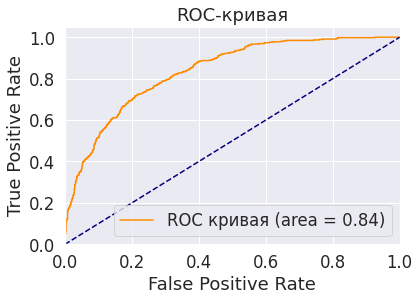

In [42]:
y = df_train['Churn']
X = df_train.drop(columns=['Churn'])
Xt = df_test.copy()

#X = pd.get_dummies(X, columns=cat_cols)
#Xt = pd.get_dummies(Xt, columns=cat_cols)


#for i in range(1,len(X.columns)):
#    X[str(i)+'_xx'] = X.iloc[:,i] * X.iloc[:,i-1]
#    Xt[str(i)+'_xx'] = Xt.iloc[:,i] * Xt.iloc[:,i-1]
    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

model_CatBoost = CatBoostClassifier(
    n_estimators=300,
    max_depth=7,
    subsample=0.6,
    l2_leaf_reg=10,
    random_strength=5,
    learning_rate=0.05,
    min_data_in_leaf=100,
    grow_policy='Lossguide',
    silent=True,
    eval_metric='AUC',
    
    cat_features=cat_cols)\
.fit(X_train,y_train,eval_set=(X_test, y_test), logging_level ='Silent', use_best_model=True,plot=True)
print(f'Обучение модели:   {model_CatBoost.is_fitted()}')
print(f'Общая точность:   {model_CatBoost.score(X_test, y_test)}')
print(f'ROC:   {roc_auc_score(y_test, model_CatBoost.predict_proba(X_test)[:,1])}')
cat_probs = model_CatBoost.predict_proba(X_test)
# сохраняем вероятности только для положительного исхода
cat_probs = cat_probs[:, 1]
# рассчитываем ROC AUC
cat_auc = roc_auc_score(y_test, cat_probs)
print('CatBoostClassifier: ROC AUC=%.5f' % (cat_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, cat_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

In [43]:
CV_Score = cross_val_score(model_CatBoost, X, y, scoring='roc_auc', cv=5)
print(CV_Score)
CV_Score.mean()

[0.85399658 0.83310886 0.83569073 0.84461009 0.83588374]


0.8406579982957265

In [44]:
# 0.8403347818234848

In [45]:
CV_Score = cross_val_score(model_CatBoost, X, y,  cv=5)
print(CV_Score)
CV_Score.mean()

[0.80416272 0.79280984 0.79356061 0.80113636 0.79734848]


0.7978036036810872

In [46]:
# 0.7983712479573406

In [47]:
submission = submission = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv')
submission['Churn'] = pd.DataFrame(model_CatBoost.predict_proba(Xt)[:, -1])
submission.to_csv('/kaggle/working/submission.csv', index=False)